In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pip install visualkeras

     |████████████████████████████████| 795 kB 5.0 MB/s 


# Import Libraries

In [2]:
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import random
import pandas as pd
from collections import Counter
from imutils import paths
import imutils
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import LinearSVC
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import visualkeras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam

# Extract data from zip file

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Semester 2/LSMA/Final Project/CNN_train.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/Semester 2/LSMA/Final Project/")
zip_ref.close()

KeyboardInterrupt: ignored

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Semester 2/LSMA/Final Project/CNN_test.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/Semester 2/LSMA/Final Project/")
zip_ref.close()

# Import data

In [3]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Semester 2/LSMA/Final Project/'

TRAIN_IMAGE_PATH = os.path.join(DATA_PATH, 'CNN_train')
TEST_IMAGE_PATH = os.path.join(DATA_PATH, 'CNN_test')

In [4]:
def get_image_filenames(image_path, image_type):
    if(os.path.exists(image_path)):
        return glob.glob(os.path.join(image_path, '*.'+image_type))
    return

In [5]:
train = get_image_filenames(TRAIN_IMAGE_PATH, "jpeg")
test = get_image_filenames(TEST_IMAGE_PATH, "jpeg")

train_size = 3000
test_size = 750

random.shuffle(train)
random.shuffle(test)

train = train[:train_size]
test = test[:test_size]

# Some functions to prepare data

### Retrieve filename

In [6]:
def FEN_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

### Retrieve square from an image

In [7]:
def get_squares_images(list_of_squares, image):
    
    # Divide the image in 64 squares and fill it into a the list
    
    # Split by row
    row_of_squares = np.array_split(image, 8)  
    
    # Split by column
    for i in range(8):
        square = np.array_split(row_of_squares[i], 8, axis=1)
        for j in range(8):
            list_of_squares.append(square[j])
    
    return list_of_squares

### Label squares thanks to FEN description

In [8]:
def get_label_from_FEN(labels, FEN_description):   
    for i in FEN_description:     
        # Test whether it's a number which means an empty squar or not
        if i.isdigit():
            k = int(i)
            for j in range(k):
                labels.append('Nothing')
        else:
            labels.append(i)        
    
    return labels

### Keep only non empty squares

In [9]:
def get_non_empty_squares(data, labels):
    new_labels = []
    new_data = data.copy()
    index = []
    
    # Scrol the list to filter out empty square
    for (i,label) in enumerate(labels):
        if label != 'Nothing':
            new_labels.append(label)
        else:
            index.append(i)       
    
    index.reverse()  
    
    for i in index:
        new_data.pop(i)   
    
    return new_data, new_labels

### Compute HSV

In [10]:
def HSV(square):  
    HSV = cv2.cvtColor(square, cv2.COLOR_BGR2HSV)
    return HSV

### Compute Gradient

In [11]:
def gradient(square):
    gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
    
    # Convert image gradient in x direction
    sobelx = cv2.Sobel(gray, 0, dx=1, dy=0)
    sobelx = np.uint8(np.absolute(sobelx))
    
    # Convert image gradient in y direction
    sobely = cv2.Sobel(gray, 0, dx=0, dy=1)
    sobely = np.uint8(np.absolute(sobely))
    
    # Compute the gradient
    gradient = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    return gradient

# Data preparation

### Train set

In [12]:
train_squares = []
train_labels = []

# Loop over the image paths in the training set
for image_path in train:
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Retrieve FEN description 
    FEN = FEN_from_filename(image_path)
    FEN = FEN.replace("-", "")
    
    # Get the 64 squares from the image
    list_of_squares_from_image = []
    get_squares_images(list_of_squares_from_image, image)
    train_squares.extend(list_of_squares_from_image)
    
    # Label the image squares
    get_label_from_FEN(train_labels, FEN)

In [13]:
# Filter out empty squares
train_filtered_squares, train_filtered_labels = get_non_empty_squares(train_squares, train_labels)

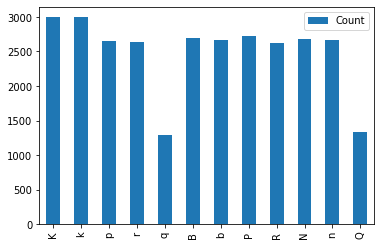

In [14]:
# Proportion of labels
counts_train = Counter(train_filtered_labels)
df_train = pd.DataFrame.from_dict(counts_train,orient='index', columns=['Count'])
df_train.plot(kind='bar')

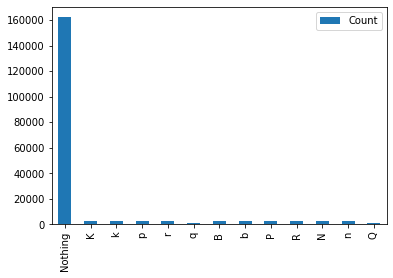

In [15]:
# Proportion of labels
counts_train = Counter(train_labels)
df_train = pd.DataFrame.from_dict(counts_train,orient='index', columns=['Count'])
df_train.plot(kind='bar')

In [16]:
# Pourcentage of non empty squares
len(train_filtered_labels) / len(train_labels)*100

15.599479166666667

### Test set

In [17]:
test_labels = []
test_squares = []

for image_path in test[:500]:
    # Load the image
    image = cv2.imread(image_path)
    
    # Retrieve FEN description 
    FEN = FEN_from_filename(image_path)
    FEN = FEN.replace("-", "")
            
    # Get the 64 squares from the image
    get_squares_images(test_squares, image)
    
    # Label the image squares
    get_label_from_FEN(test_labels, FEN)

In [18]:
# Filter out empty square
test_filtered_squares, test_filtered_labels = get_non_empty_squares(test_squares, test_labels)

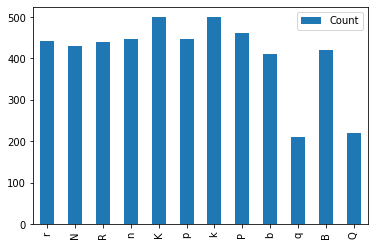

In [19]:
# Proportion of labels
counts_test = Counter(test_filtered_labels)
df_test = pd.DataFrame.from_dict(counts_test, orient='index', columns=['Count'])
df_test.plot(kind='bar')

In [20]:
len(test_filtered_labels) / len(test_labels)*100

15.403125000000001

# Classify empty squares from non empty ones

In [150]:
dframe = pd.DataFrame(train_labels, columns=['label'])  
dframe['square'] = train_squares
dframe.head()

,label,square
0,Nothing,"[[[138, 121, 102], [140, 123, 104], [142, 124,..."
1,Nothing,"[[[91, 75, 59], [82, 67, 51], [88, 72, 60], [9..."
2,Nothing,"[[[146, 131, 115], [132, 118, 100], [136, 121,..."
3,Nothing,"[[[88, 70, 59], [81, 63, 52], [95, 78, 69], [9..."
4,Nothing,"[[[142, 126, 110], [137, 121, 105], [139, 120,..."


### Compute features

In [151]:
dframe['HSV'] = dframe['square'].apply(HSV)
dframe['gradient'] = dframe['square'].apply(gradient)

In [152]:
dframe['mean_H'] = dframe['HSV'].apply(lambda x: x[..., 0].mean())
dframe['std_H'] = dframe['HSV'].apply(lambda x: x[..., 0].std())
dframe['mean_S'] = dframe['HSV'].apply(lambda x: x[..., 1].mean())
dframe['std_S'] = dframe['HSV'].apply(lambda x: x[..., 1].std())
dframe['mean_V'] = dframe['HSV'].apply(lambda x: x[..., 2].mean())
dframe['std_V'] = dframe['HSV'].apply(lambda x: x[..., 2].std())
dframe['mean_gradient'] = dframe['gradient'].apply(lambda x: x.mean())

In [153]:
dframe['empty'] = dframe['label'].apply(lambda x: 1 if x == 'Nothing' else 0)

In [154]:
dframe = dframe.drop(['square', 'gradient', 'HSV', 'label'], axis=1)

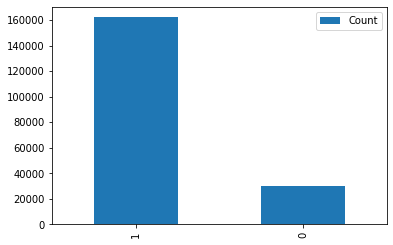

In [155]:
counts_test = Counter(dframe['empty'])
df_test = pd.DataFrame.from_dict(counts_test, orient='index', columns=['Count'])
df_test.plot(kind='bar')

### Define Train and Test set

In [156]:
X, y = dframe.iloc[:, 0:7].values, dframe.iloc[:, 7].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [157]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Train a SVM classifier

In [158]:
# Training
SVM_detection = LinearSVC()
SVM_detection.fit(X_train_std, y_train)
print('Training accuracy:', SVM_detection.score(X_train_std, y_train))
print('Test accuracy:', SVM_detection.score(X_test_std, y_test))

Training accuracy: 0.99515625
Test accuracy: 0.9949826388888889


In [159]:
# Compute confusion matrix
prediction_SVM = SVM_detection.predict(X_test_std)
cm_svm = confusion_matrix(y_test, prediction_SVM)

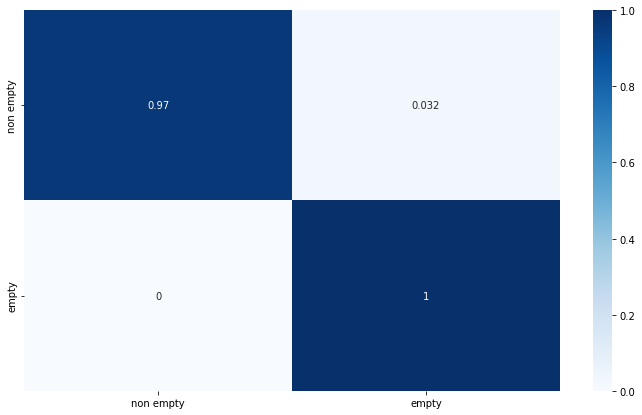

In [160]:
# Normalize confusion matrix
cm_normalize = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]

cm_normalize_df = pd.DataFrame(cm_normalize, ['non empty', 'empty'], ['non empty', 'empty'])                      
plt.figure(figsize=(12,7))
sns.heatmap(cm_normalize_df, annot=True, cmap='Blues')

# Classify type of pawn

## Building the model

In [37]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0

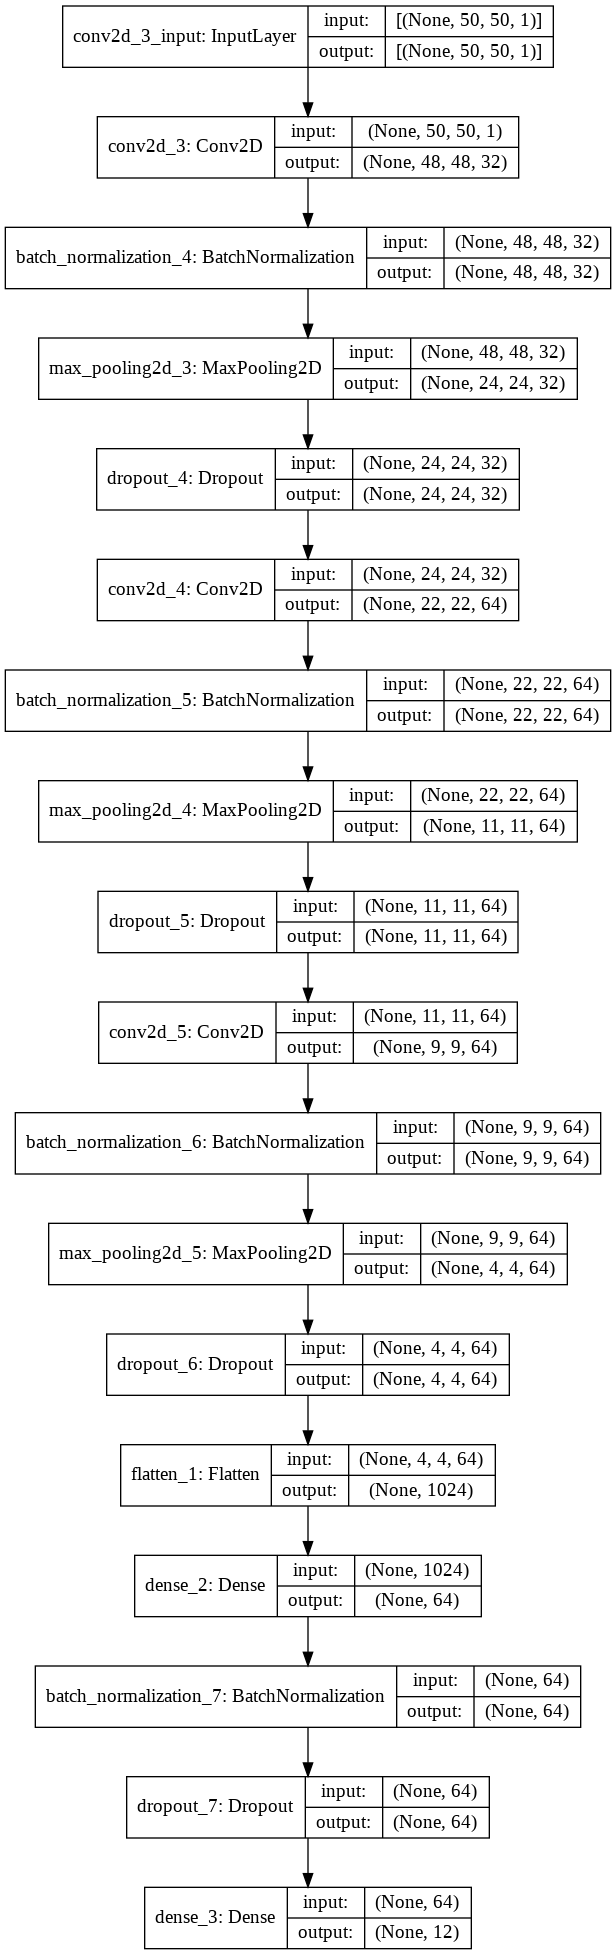

In [ ]:
plot_model(model,show_shapes=True, show_layer_names=True)

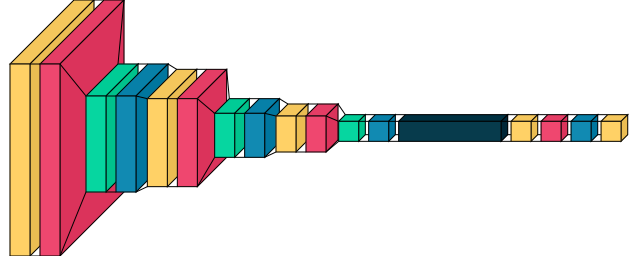

In [ ]:
visualkeras.layered_view(model)

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

#optimizer='adam'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Training and evaluation of the model

In [39]:
df_train = pd.DataFrame(train_filtered_labels, columns=['label'])  
df_train['square'] = train_filtered_squares

df_test = pd.DataFrame(test_filtered_labels, columns=['label'])  
df_test['square'] = test_filtered_squares

In [40]:
onehot_train = pd.get_dummies(df_train['label'])
pawn = onehot_train.columns
onehot_train = onehot_train.to_numpy()

onehot_test = pd.get_dummies(df_test['label'])
onehot_test = onehot_test.to_numpy()

In [41]:
# Transpose to gray
train_gray = []
for square in train_filtered_squares: 
    gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
    train_gray.append(gray)

test_gray = []
for square in test_filtered_squares: 
    gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
    test_gray.append(gray)

In [42]:
# Scaling up 
x_train = np.array(train_gray) / 255.0
x_train = np.expand_dims(x_train, axis=3)

x_test = np.array(test_gray) / 255.0
x_test = np.expand_dims(x_test, axis=3)

In [43]:
# History to analyze training evolution
history = model.fit(x_train, 
                    onehot_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(x_test, onehot_test),
                    verbose=1)

Epoch 1/5
234/234 [==============================] - 37s 29ms/step - loss: 0.4812 - accuracy: 0.8568 - val_loss: 1.0162 - val_accuracy: 0.6269
Epoch 2/5
234/234 [==============================] - 6s 27ms/step - loss: 0.0651 - accuracy: 0.9863 - val_loss: 0.0374 - val_accuracy: 0.9931
Epoch 3/5
234/234 [==============================] - 6s 27ms/step - loss: 0.0332 - accuracy: 0.9943 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 4/5
234/234 [==============================] - 6s 27ms/step - loss: 0.0223 - accuracy: 0.9963 - val_loss: 0.0196 - val_accuracy: 0.9933
Epoch 5/5
234/234 [==============================] - 6s 27ms/step - loss: 0.0162 - accuracy: 0.9976 - val_loss: 0.0013 - val_accuracy: 1.0000


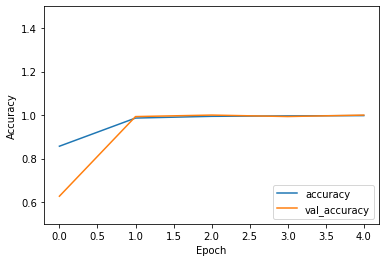

In [44]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.5])
plt.legend(loc='lower right')

# Generate FEN from an image

### Some functions to apply the classifier and return the FEN descriptor

In [174]:
def FEN_from_classifier(path):
    image = cv2.imread(path)
    FEN_description = []
    list_of_squares = []
    list_of_squares = get_squares_images(list_of_squares,image)
    column = 0
    k = 0
    
    for i in range(len(list_of_squares)):
        column = column + 1
        gray = cv2.cvtColor(list_of_squares[i], cv2.COLOR_BGR2GRAY)
        
        # Compute features for detecting non-empty square
        grad = gradient(list_of_squares[i])
        hsv = HSV(list_of_squares[i])
        mean_H = hsv[..., 0].mean()
        std_H = hsv[..., 0].std()
        mean_S = hsv[..., 1].mean()
        std_S = hsv[..., 1].std()
        mean_V = hsv[..., 2].mean()
        std_V = hsv[..., 2].std()
        mean_gradient = grad.mean()
        features = np.array([mean_H, std_H, mean_S, std_S, mean_V, std_V, mean_gradient])      
        
        # Standardization
        features = stdsc.transform(features.reshape(1, -1))
        
        # Predict whether it's empty or not
        empty = SVM_detection.predict(features)    
        
        # Check whether the square is empty or not
        if empty == 1:
            FEN_description.append('1')
        else:
            # Fit data before classifying   
            data = np.array(gray) / 255.0
            data = np.expand_dims(data, axis=2)
            data = np.expand_dims(data, axis=0)
            # Classify the pawn
            prediction = model.predict(data)
            prediction = pawn[np.argmax(pred, axis = 1)[0]]
            FEN_description.append(prediction)
        
        # Add "-" to notify we change the row
        if column == 8:
            FEN_description.append('-')
            column = 0  
    
    FEN_description = suitable_form(FEN_description)   
    
    return FEN_description

In [175]:
def suitable_form(FEN_description):
    A = ''
    k = 0
    
    for i in FEN_description:
        if i.isdigit():
            k = k + 1
        elif i == '-':
            A = A + str(k) + '-'
            k = 0
        else:
            A = A + str(k) + i
            k = 0
    A = A.replace('0','')
    A = A[:-1] 
    
    return A

In [176]:
def box_checking(FEN):
    A = ''
    
    for p in FEN:
        if p.isdigit():
            k = ''
            for j in range(int(p)):
                k = k + '1'
            A = A + k
        else:
            A = A + p
    
    return A

### Evaluate

In [182]:
accuracy = 0

for path in test:
    FEN_predicted = FEN_from_classifier(path)
    FEN = FEN_from_filename(path)
    
    FEN_predicted = box_checking(FEN_predicted)
    FEN = box_checking(FEN)
    
    # Sum number of good predicted boxes
    FEN_accuracy = sum([1 for i,j in zip(FEN_predicted,FEN) if i==j]) - 7 # Soustract number of "-"
    
    accuracy = accuracy + FEN_accuracy / 64

In [183]:
100*accuracy / len(test)

85.80208333333333